In [6]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import analyze_utils

save_dir = '/home/jxm3/research/prompting/interpretable-autoprompting/results_icml/ablation_math_across_difficulty_levels'

r, all_losses = analyze_utils.load_results_and_cache_autoprompt_json(
    save_dir, include_losses=True, do_reranking=False, save_file='r.pkl')

getting dir_names...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 157/159 [00:03<00:00, 44.24it/s]

skipping /home/jxm3/research/prompting/interpretable-autoprompting/results_icml/ablation_math_across_difficulty_levels/Jan_17_17_13_hgyruofoodcc/results.pkl (run still in progress?)
skipping /home/jxm3/research/prompting/interpretable-autoprompting/results_icml/ablation_math_across_difficulty_levels/Jan_17_17_29_dnhfvyqbgtaa/results.pkl (run still in progress?)
skipping /home/jxm3/research/prompting/interpretable-autoprompting/results_icml/ablation_math_across_difficulty_levels/Jan_17_17_29_lkoipieyflrb/results.pkl (run still in progress?)
skipping /home/jxm3/research/prompting/interpretable-autoprompting/results_icml/ablation_math_across_difficulty_levels/Jan_17_17_29_swxyywntbyel/results.pkl (run still in progress?)
skipping /home/jxm3/research/prompting/interpretable-autoprompting/results_icml/ablation_math_across_difficulty_levels/Jan_17_17_29_tdcnoedmtetr/results.pkl (run still in progress?)
skipping /home/jxm3/research/prompting/interpretable-autoprompting/results_icml/ablation_m

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:03<00:00, 50.64it/s]


skipping /home/jxm3/research/prompting/interpretable-autoprompting/results_icml/ablation_math_across_difficulty_levels/Jan_17_17_29_vqwnutsqohvr/results.pkl (run still in progress?)
skipping /home/jxm3/research/prompting/interpretable-autoprompting/results_icml/ablation_math_across_difficulty_levels/Jan_17_17_32_iibjmvppmqti/results.pkl (run still in progress?)


In [8]:
min([len(L) for L in all_losses])

126

In [9]:
top_prompts = (
    r.groupby(['task_name', 'seed', 'max_digit'])
).first().reset_index()
top_prompts[['task_name', 'seed', 'max_digit', 'prefixes', 'reciprocal_rank']]

,task_name,seed,max_digit,prefixes,reciprocal_rank
0,subtract_two,1,10,Find a number where 0 <,0.333333


<AxesSubplot:ylabel='max_digit'>

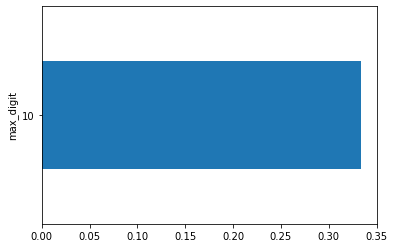

In [10]:
top_prompts.groupby('max_digit').mean()['reciprocal_rank'].plot(kind='barh')

In [21]:
top_prompts['reciprocal_rank'].mean()

0.13830458898775724

In [19]:
assert r['checkpoint'].unique()[0] == "EleutherAI/gpt-j-6B"

In [5]:
from iprompt import prompt_classification

model = prompt_classification.create_model(r['checkpoint'].unique()[0])

2023-01-17 15:40:20.579743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 15:40:20.761782: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-17 15:40:20.798810: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-17 15:40:21.879204: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [6]:
## Compute accuracy given correct prompt and save for each task.
import argparse
from tqdm.notebook import tqdm
from iprompt.data import get_data


data = []
print('calculating accs...')
n_shots = 1
batch_size = 16

"""
task_name: str = 'add_two',
 n_shots: int = 1,
 train_split_frac: float = None,
 max_dset_size: int = 10000,
 template_num_task_phrasing: int = 0,
 max_digit: int = 10,
 """

for _, output in tqdm(top_prompts.iterrows(), total=len(top_prompts)):
    args = argparse.Namespace(**output)
    (dset, dset_test), check_answer_func, descr = get_data(
        args.task_name, n_shots=n_shots, train_split_frac=args.train_split_frac,
        max_dset_size=args.max_dset_size, template_num_task_phrasing=0,
        max_digit=args.max_digit,
    )
    # if task_name == 'task107_splash_question_to_sql':
    #     batch_size = max(1, batch_size//4)
    ####   Manual prompt  ####
    manual_loss, manual_acc = prompt_classification.test_model_on_task_with_prefix(
        dset=dset, model=model, prefix=descr, multi_token=False, verbose=False,
        batch_size=batch_size,
    )
    ####   iPrompt prompt   ####
    iprompt_loss, iprompt_acc = prompt_classification.test_model_on_task_with_prefix(
        dset=dset, model=model, prefix=output['prefixes'], multi_token=False, verbose=False,
        batch_size=batch_size,
    )
    ####
    output['manual_acc'] = manual_acc
    output['iprompt_acc'] = iprompt_acc
    data.append(output)

calculating accs...


  0%|          | 0/150 [00:00<?, ?it/s]

In [21]:
output['prefixes']

' Given n positive integers that add'

In [24]:
import os

# top_prompts_df = pd.DataFrame(data)
# top_prompts_df.to_pickle(os.path.join(save_dir, 'top_prompts.pkl'))
top_prompts_df = pd.read_pickle(os.path.join(save_dir, 'top_prompts.pkl'))

In [25]:
top_prompts_df['prompt_ratio'] = top_prompts_df['manual_acc'] / top_prompts_df['iprompt_acc']

In [56]:
top_prompts_df.groupby(['task_name', 'max_digit']).mean()['manual_acc']

task_name      max_digit
add_two        10            76.444444
               20            56.666667
               40            48.833333
               80            32.000000
               160           10.866667
divide_two     10            10.666667
               20             3.666667
               40             3.916667
               80             5.133333
               160            8.866667
double_one     10           100.000000
               20           100.000000
               40            96.666667
               80            95.000000
               160           71.666667
exp_one        10            14.285714
               20            13.333333
               40             3.333333
               80            10.000000
               160           10.000000
fibonacci_one  10            71.428571
               20            20.000000
               40            13.333333
               80             3.333333
               160            5.833333


<AxesSubplot:xlabel='max_digit', ylabel='manual_acc'>

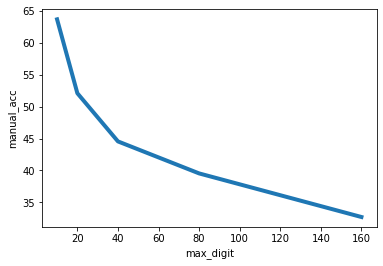

In [62]:
task_acc_percent = ((
            top_prompts_df.groupby(['max_digit']).mean()
        ) 
        / 
        (1 
            # top_prompts_df.groupby(['task_name']).max()['manual_acc'] - top_prompts_df.groupby(['task_name']).min()['manual_acc']
        )
).reset_index()

# task_acc_percent = task_acc_percent[
#     task_acc_percent['task_name'].map(lambda s: s not in [''])
# ]

sns.lineplot(data=task_acc_percent, x='max_digit', y='manual_acc', linewidth=4)

In [68]:
sns.lineplot(data=task_acc_percent, x='max_digit', y=['manual_acc', 'iprompt_acc'], linewidth=4)

ValueError: Length of list vectors must match length of `data` when both are used, but `data` has length 5 and the vector passed to `y` has length 2.

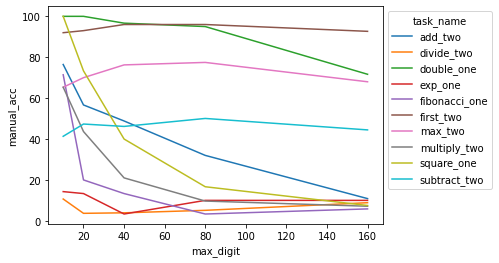

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

r_grouped_by_task = (
    top_prompts_df
     .groupby(['max_digit', 'task_name']).mean()
     .reset_index()
)

ax = sns.lineplot(
    data=r_grouped_by_task, x='max_digit', y='manual_acc', hue='task_name',
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) # legend outside of plot
# ax.set_yscale('log')

In [38]:
top_prompts_df[top_prompts_df['reciprocal_rank'] < 0.1][['prefixes','reciprocal_rank','task_name']]

,prefixes,reciprocal_rank,task_name
0,Input two positive integer values,0.066667,add_two
9,Input three natural-number pairs,0.071429,add_two
16,"1 /, 2 %",0.011905,divide_two
17,Input two integers m (the,0.024390,divide_two
19,Given a fraction F (a,0.037037,divide_two
...,...,...,...
144,"Given 3 digits x, y",0.083333,subtract_two
145,Write a function named sum,0.066667,subtract_two
146,1 Given 2 Prompt 3 <,0.045455,subtract_two
148,"Given 3 positive integers a,",0.030303,subtract_two


## Plot losses

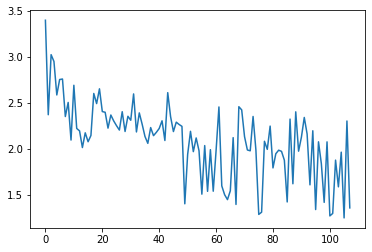

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


plt.plot(np.array(all_losses[20]))